# Omega implementation of Peroxisome Dynamics

In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions
using CSV
using DataFrames
using Flux
using DataStructures

Internal error: encountered unexpected error in runtime:
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\rtutils.c:187
getindex at .\array.jl:731
jfptr_getindex_2272.clone_1 at C:\Users\Devon Kohler\AppData\Local\Julia-1.0.5\lib\julia\sys.dll (unknown line)
jl_apply_generic at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\gf.c:2162
replace_code_newstyle! at .\compiler/ssair\legacy.jl:86

## Implement Gillespie Model

In [11]:
function simulation(rng, n, transitions)
    
    """
    Compute the hazard function given the current states.
    args:
        rng(): julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
    """
    
    ecology = Dict("X" => X_val_list[n])

    hazards = Dict(
        "H1" => theta["r1"],
        "H2" => ecology["X"]*theta["r2"],
        "H3" => ecology["X"]*theta["r3"]
        )

    vals = collect(values(hazards))
    sum_vals = sum(vals)
    new_t = t_list[n] + Omega.exponential(rng, 1/sum_vals)
    push!(t_list, new_t)
    
    prob_vals = vals/sum_vals
    hazard_result = Omega.categorical(rng, prob_vals)
    
    labels = ["H1", "H2", "H3"]
    transition = transitions[labels[hazard_result]]
    new_X = ecology["X"] + transition[1]

    # Enforce only positive integers
    new_x = max(1, new_X)
    push!(X_val_list, new_x)
    [new_x, new_t]
    
end

simulation (generic function with 1 method)

In [12]:
## Transition Matrix
Pre = [[0], [0], [0]]
Post = [[1], [1], [-1]]
transition_mat = Post - Pre
transitions = OrderedDict("H1" => transition_mat[1,],
                    "H2" => transition_mat[2,],
                    "H3" => transition_mat[3,])

OrderedDict{String,Array{Int64,1}} with 3 entries:
  "H1" => [1]
  "H2" => [1]
  "H3" => [-1]

In [13]:
# Initial Prey and Pred values
X_init = 240

# Rate Values
r1 = 2.51e-4
r2 = 10e-5
r3 = 10.5e-5

theta =  OrderedDict("r1" => r1,
         "r2" => r2,
         "r3" => r3)

OrderedDict{String,Float64} with 3 entries:
  "r1" => 0.000251
  "r2" => 0.0001
  "r3" => 0.000105

In [14]:
## Initialize lists and add starting rand vars
rand_var_list = Any[]
X_val_list = Any[]
t_list = Any[]
push!(X_val_list, X_init)
push!(t_list, 0)

## How many time periods to cycle over
N = 3500

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    X_temp = ciid(simulation, last, transitions) # individual step
    push!(rand_var_list, X_temp)
end

## Convert lists to single tuple
random_var_tuple = Tuple(x for x in rand_var_list)#...)
print()

In [15]:
## Sample
Random.seed!(1234)
samples = rand(random_var_tuple, 1, alg = RejectionSample)
print()

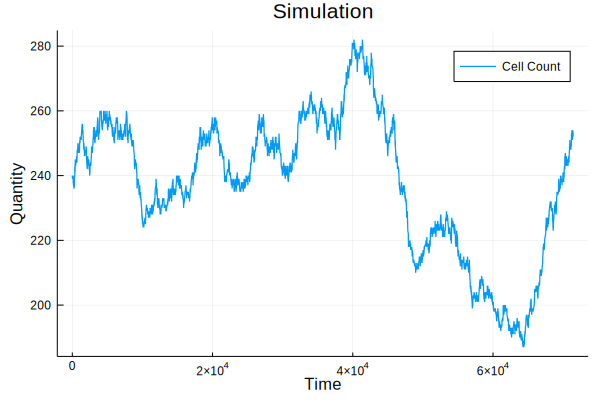

In [16]:
plot(t_list[1:N], X_val_list[1:N],
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = "Cell Count",
    lw = 1.25)

## Load dataset

In [2]:
day1 = CSV.read("C:/Users/Devon Kohler/Documents/Northeastern/Research/Causal_Inference/SDE_inference/Experimental_Data/Data/Day1/all.dat", DataFrame)#, delim = ',')#, '\n')
day2 = CSV.read("C:/Users/Devon Kohler/Documents/Northeastern/Research/Causal_Inference/SDE_inference/Experimental_Data/Data/Day2/all.dat", DataFrame)
day3 = CSV.read("C:/Users/Devon Kohler/Documents/Northeastern/Research/Causal_Inference/SDE_inference/Experimental_Data/Data/Day3/all.dat", DataFrame)
print()

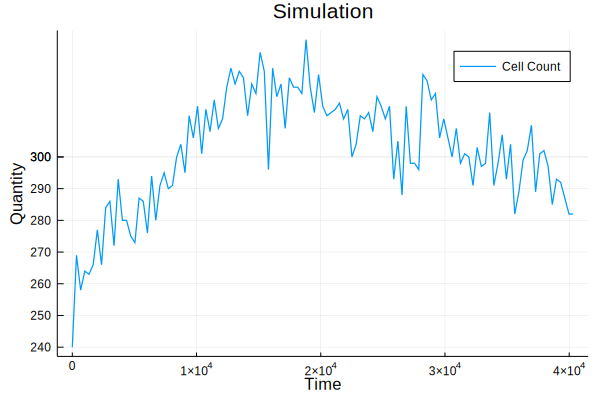

In [18]:
plot(day1[day1.Cell .== 1, :time],
    day1[day1.Cell .== 1, :count],
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = "Cell Count",
    lw = 1.25)

### Steps to run causal inference on experimental data

1. Build Gillespie Simulation of Peroxisome Dynamics (Done)
    1. We assume the true relationship between cell count and time follows this simulation
2. Condition simulation on observed data - $P(Count_T | Data)$
    1. Use time points and counts as conditionals, allowing for some variablility between observed counts
3. Use Omega replace function to run counterfactuals on conditioned simulation
4. We have 43 traces we can do this process on

## Different Form of Equation

Given join effect of three stochastic processes, the probabiliy $p(x, t)$ that the count equals x at time t is governed by the following equation

$$\frac{dp(x,t)}{dt} = [k_d + k_f(x-1)]p(x-1,t) + [\gamma(x+1)]p(x+1,t)-[k_d+(k_f + \gamma)x]p(x,t)$$

This can be further reformulated as an SDE:

$$dx(t) = [k_d + (k_f - \gamma)x(t)]dt + [k_d + (k_f + \gamma)x(t)]dW(t)$$

Where $W(t)$ is Brownian motion. Finally this equation can be solved with the Euler-Maruyama method.

$$x_{t+1} = [k_d + (k_f - \gamma)x_t]\Delta t + [k_d + (k_f + \gamma)x(t)]\sqrt{\Delta t}Z$$

$$Z \sim N(0,1)$$

Since we know $Z$ is a random variable, $x_{t+1}$ must also be a random variable. 

Additionally there is also a presence of measurement error, which accounts for the difference between the true counts $x_t$ and the observed count $y_t$. This error is governed by the equation:

$$p(y_t|x_t) = N(x_t, \sigma^2)$$

What if we use these two equation as our functional form and sample from this new distribution. Since $p(x,t)$ is the joint effect of stochastic processes we would expect this to be very similar to gillespie, however we can break away from the gillespie time component.

$$x_{t+1} + N(x_{t+1}, \sigma^2)$$

### Day 1 - Cell 1 Test Implementation

We take the rate parameters from the paper "Statistical Inference of Peroxisome Dynamics" by Cyril Galitzine, Pierre M. Jean Beltran, IleanaM.Cristea, and Olga Vitek. These are as follows:

$k_d = .000215, k_f = .0001, \gamma = .000105$

Addtionally $x_0 = 240$, thus $p(240, 0) = 1$

With these parameters lets estimate $p(x, 1)$, the probability the count equals x at time 1.

In [257]:
kd = .00251
kf = .0010
g = .00105

0.00105

In [262]:
cell1 = day1[day1.Cell .== 3,:]

,Column1,time,count,Cell
,Int64,Int64,Int64,Int64
1,704,0,521,3
2,705,336,540,3
3,706,672,519,3
4,707,1008,538,3
5,708,1344,546,3
6,709,1680,543,3
7,710,2016,552,3
8,711,2352,551,3
9,712,2688,532,3


In [275]:
function back_calc(x, x_next, diff_t)
    norm_eval = (x_next - diff_t*(kd + (kf - g)*x))*sqrt(diff_t) / ((kd + (kf + g)*x)*diff_t)
end

back_calc (generic function with 1 method)

In [278]:
back_calc(519,520,336)

27.00334567432259

In [277]:
(kd + (kf - g)*240)*336 + (kd + (kf + g)*240)*sqrt(336)*29.807

266.9974488501769

In [208]:
function x_sim(rng, n, diff_t)
    x = x_vals[n]
    x_next = (kd + (kf - g)*x)*diff_t + (kd + (kf + g)*x)*sqrt(diff_t)*normal(rng,0,1)
    insert!(x_vals, n+1, x + x_next)
    return x + x_next
end

x_sim (generic function with 1 method)

In [4]:
sim = ciid(x_sim, 1, 336)
rand(sim, 5, alg = RejectionSample)

1:Omega.reifyapply(x_sim, 1, 336)::Any

In [5]:
x_vals = Any[]
push!(x_vals, 240)
sim_steps = Any[]

N = 121
for n in 2:N
    sim = ciid(x_sim, n-1, 336)
    push!(sim_steps, sim)
end

In [6]:
Random.seed!(1234)
sim_samples = rand(Tuple(sim_steps), 1, alg = RejectionSample)

1-element Array{NTuple{120,Float64},1}:
 (246.5790071830665, 257.95377632423094, 263.7473441680598, 266.71062481845007, 279.26389899242497, 294.5556207480729, 288.3620471254074, 285.98251898158554, 281.94103432885333, 287.86061264899956, 295.7694176573215, 272.68703965812085, 260.44734201411444, 282.0706804668425, 289.92830925701617, 279.71309181609723, 276.92308093657346, 284.94015330100956, 270.9021969874508, 285.48481774378206, 307.5788282391198, 332.56951495997413, 356.2147124592057, 369.8246758665624, 385.250772490622, 359.98420483701653, 344.00089580753354, 340.2037899117301, 327.86615504975583, 326.6918586510761, 348.53948398375155, 349.0344227707984, 342.31301790124684, 314.84604539083034, 297.2859129849782, 300.6134048429558, 311.27235602374725, 308.0685669619639, 309.7892269430737, 326.94449568499977, 308.4476894628116, 317.96181794734304, 316.7748898071326, 313.4911487505704, 312.67954898350615, 303.2321676496241, 294.1482787924929, 291.04573143697496, 291.8483005419427, 295

In [7]:
x_vals = Any[]
push!(x_vals, 240)
sim_steps = Any[]

N = 121
for n in 2:N
    if n == 3
        sim_ = ciid(x_sim, n-1, 336)
        sim_ = cond(sim_, 250 <= sim_)
        sim = cond(sim_, sim_ <= 264)
    elseif n == 30
        sim_ = ciid(x_sim, n-1, 336)
        sim_ = cond(sim_, 300 <= sim_)
        sim = cond(sim_, sim_ <= 312)
    else
        sim = ciid(x_sim, n-1, 336)
    end
    push!(sim_steps, sim)
end

In [8]:
Random.seed!(1234)
sim_samples = rand(Tuple(sim_steps), 1, alg = RejectionSample)

1-element Array{NTuple{120,Float64},1}:
 (238.1836196911542, 251.55481669583781, 255.39008820888938, 263.5100427163277, 282.90763769452053, 268.8762637372278, 269.80765678906795, 259.97132778965357, 269.1764219845311, 253.22340353093003, 261.14373820594375, 277.93336650532444, 276.4443818866096, 283.3852850294578, 283.9748735855945, 269.89618548256755, 274.2367214673829, 282.4300391601926, 292.16771333960025, 284.69170068896113, 287.0904841064775, 272.5126689374973, 264.74031391182314, 274.1564118139996, 289.8670469350735, 312.3824868870224, 308.87239293581, 308.1883777976382, 311.66815744564207, 312.2480769689772, 298.6153625812307, 296.0251409057189, 305.2481392956373, 313.9672731540392, 303.7431195344879, 306.140900984329, 304.2170958207925, 284.6130730233931, 305.3795516646569, 318.45842553791977, 316.36193614554486, 334.0457519606407, 346.4121533091087, 335.4540568756554, 351.9737696106999, 359.8152488237461, 378.0533385908642, 385.48844197790515, 400.043441215461, 403.96634895348

In [35]:
plot_counts = append!([240.], [i for i in sim_samples[1]])

121-element Array{Float64,1}:
 240.0             
 242.5385024462492 
 260.2723478931068 
 277.505090296421  
 274.2463029768614 
 268.3269550381685 
 289.06818804667336
 308.1181533614363 
 299.2192728806159 
 277.1191725678781 
 285.9501457702618 
 287.9727248200293 
 297.62554589737243
   ⋮               
 345.8991696271854 
 392.0830210902471 
 408.8544509905692 
 376.1479405674807 
 378.18422630857   
 394.96064921049253
 430.4267317992026 
 422.5827207870475 
 428.68957092798746
 455.12470552213676
 426.7892412667807 
 449.52349815084216

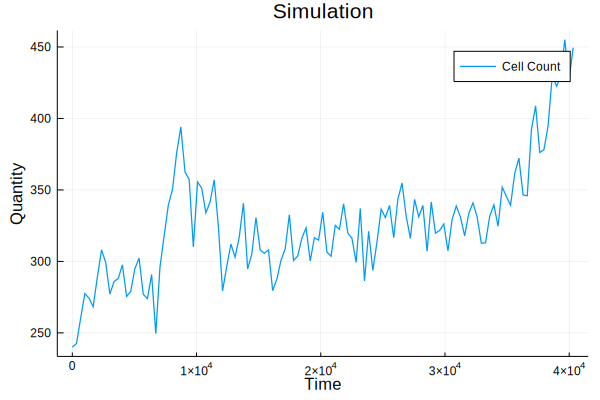

In [36]:
plot(day1[day1.Cell .== 1, :time],
    plot_counts,
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = "Cell Count",
    lw = 1.25)

In [281]:
cell1 = day1[day1.Cell .== 1,:]
print()

In [282]:
cell1[cell1.time .== 336, :count][1]

269

In [287]:
x_vals = Any[]
push!(x_vals, cell1[1, :count])
sim_steps = Any[]
time_arr = Array(cell1[:, :time])

N = 336
for n in 2:N
    cond_val = cell1[cell1.time .== n, :count][1]
    sim_ = ciid(x_sim, n-1, 336)
    sim = cond(sim_, sim_ ==ₛ cond_val)
    push!(sim_steps, sim)
end

BoundsError: BoundsError: attempt to access 0-element Array{Int64,1} at index [1]

In [285]:
sim_samples = rand(Tuple(sim_steps), 1, alg = HMCFAST)
print()

1-element Array{NTuple{1451,Tracker.TrackedReal{Float64}},1}:
 (240.6097773336201, 246.11659759653548, 246.59211476250636, 247.86074061056286, 248.15543088639413, 248.99371112961768, 250.9266009019769, 250.60105463357473, 251.46931659709543, 254.739505440097, 253.55245925349388, 252.7205614531314, 250.82580992891303, 249.42302227166917, 247.7640558379337, 249.46731262870853, 251.37462153219465, 250.9190644313393, 252.55239014232708, 252.4679330519158, 254.8396514811447, 254.5810437130187, 255.9137455668892, 254.139283291993, 254.40208133670518, 252.19354216394714, 249.15956357446473, 250.90541237151444, 249.19624128923334, 249.3391484742662, 248.45657795862846, 251.09062617429183, 251.50018749187169, 253.8344997490004, 252.83753741575742, 251.22117745337977, 251.76890820856926, 249.82324737775738, 249.3247298372919, 247.8833616836235, 250.18837230975288, 251.30484241802765, 249.25116071768758, 249.93778252520528, 249.58550655150123, 247.32528842031175, 247.13061264066238, 248.209412112

In [254]:
sim_samples

1-element Array{NTuple{1451,Tracker.TrackedReal{Float64}},1}:
 (240.03052823754365, 245.20790331321362, 244.24834802077112, 249.0184575715231, 248.60602139091077, 250.43389846947883, 252.59224103471664, 253.4643610422861, 255.71784739289708, 255.85469819948742, 254.22076053956908, 253.87444841420043, 251.5615996576871, 249.68538316447717, 251.66960172680595, 248.62717576146702, 248.34358084976182, 246.869202802978, 243.50289787622083, 241.2686216955132, 240.4352457296368, 240.67778569483986, 241.95158162606083, 241.22322818035454, 242.67534680874357, 242.83537369974763, 242.32868970476028, 242.8715693210592, 242.25228686572757, 241.66003391025788, 241.19480790478428, 242.0784312100063, 243.1960939530836, 243.7131237590389, 245.62611075098764, 246.94415735361457, 247.9368218182729, 247.70080708667885, 249.35144182182498, 251.4145803254449, 254.64395909044987, 256.1357734684216, 255.78738826530554, 254.20160717145652, 252.38953691271033, 252.22949932825168, 253.38435837485994, 254.041338

In [286]:
plot(day1[day1.Cell .== 1, :time][1:N],
    hcat(day1[day1.Cell .== 1,:count][1:N], append!([Float64(cell1[1, :count])], Array([Tracker.data(i) for i in sim_samples[1]]))),
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = ["True Count" "Sim Count"],
    lw = 1.25)

BoundsError: BoundsError: attempt to access 121-element Array{Int64,1} at index [1:1452]

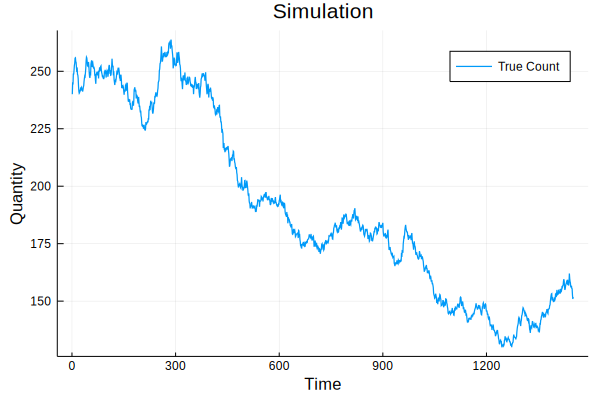

In [256]:
plot(
    Array([Tracker.data(i) for i in sim_samples[1]]),
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = ["True Count" "Sim Count"],
    lw = 1.25)

In [142]:
cond_val = cell1[2, :count]
sim_ = ciid(x_sim, 1, 336)
sim = cond(sim_, sim_ ==ₛ cond_val)
Random.seed!(20)
rand(sim, alg = HMCFAST)

278.79312654569867 (tracked)

In [124]:
cond_val

269

In [279]:
rand(sim_ ==ₛ cond_val)

Omega.Soft.DualSoftBool{SoftBool{Tracker.TrackedReal{Float64}}}(ϵ:0.0 (tracked), ϵ:-1.4844530642623717e7 (tracked))